# Load as a torchaudio style dataset

This notebook requires `librosa` and `matplotlib` beyond `pmqd`. Uncomment below to install the requirements.

In [1]:
#!pip install git+https://github.com/Peltarion/pmqd#egg=pmqd
#!pip install librosa matplotlib

----------

In [2]:
import itertools
import random
from typing import Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio.transforms as T
from IPython.display import Audio
from librosa.display import specshow
from pmqd.torch import PMQD
from torch.utils.data import Dataset, DataLoader, Subset

First load the dataset and extract the sample_rate.

In [3]:
dataset = PMQD(root="download_directory", download=True)
sample_rate = PMQD.SAMPLE_RATE

Now we can listen to a few random samples from the dataset.

In [4]:
for i in random.choices(range(len(dataset)), k=5):
    example = dataset[i]
    audio, rating = example["audio"], example["rating"]
    
    degradation_type = example["degradation_type"]
    degradation_intensity = example["degradation_intensity"]

    print(f"Degradation {degradation_type}({degradation_intensity:.2f}%) with rating {rating}: ")
    display(Audio(audio.numpy(), rate=sample_rate))

Degradation distortion(47.55%) with rating 1.0: 


Degradation original(0.00%) with rating 5.0: 


Degradation distortion(99.23%) with rating 1.0: 


Degradation original(0.00%) with rating 4.0: 


Degradation lowpass(0.73%) with rating 4.0: 


To produce the results in our paper [Perceiving Music Quality with GANs](https://arxiv.org/abs/2006.06287), we used a preprocessing pipeline equivalent to the follwing. It creates log mel spectrogram from the first channel with the shape 256 x 256 (frequency x time).

In [5]:
class TransformedPMQD(Dataset):
    """Transform the first channel of audio and return it together with the rating."""
    
    def __init__(self, dataset: PMQD, transforms: nn.Sequential):
        self.dataset = dataset
        self.transforms = transforms
    
    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, n: int) -> Tuple[torch.Tensor, torch.Tensor]:
        example = self.dataset[n]
        channel = example["audio"][0]
        return self.transforms(channel), example["rating"]

In [6]:
reduced_sample_rate = 16000
window_size = 2048
hop_size = 256
num_mels = 128

In [7]:
transforms = nn.Sequential(
    T.Resample(orig_freq=sample_rate, new_freq=reduced_sample_rate),
    T.MelSpectrogram(
        n_mels=num_mels,
        n_fft=window_size,
        win_length=window_size,
        hop_length=hop_size,
        power=1,
        center=False,
        sample_rate=reduced_sample_rate,
        f_min=0,
        f_max=reduced_sample_rate / 2,
        window_fn=torch.hann_window
    ),
)

/usr/local/anaconda3/envs/pmqd/lib/python3.6/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/anaconda3/envs/pmqd/lib/python3.6/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


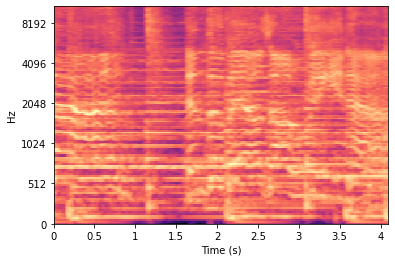

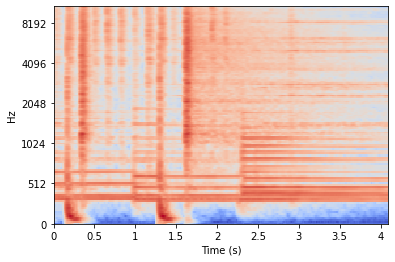

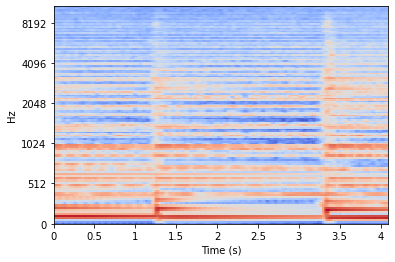

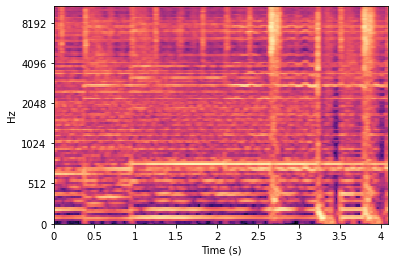

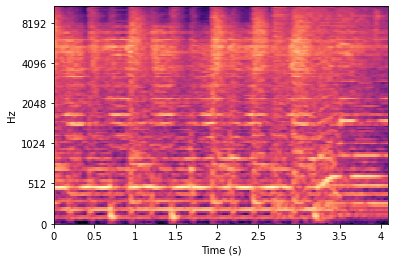

In [8]:
dataloader = DataLoader(TransformedPMQD(dataset, transforms), batch_size=32)
for mel_spectrograms, rating in itertools.islice(dataloader, 0, 5):
    specshow(
        torch.log(mel_spectrograms[0] + 1e-3).numpy(),
        sr=reduced_sample_rate,
        hop_length=hop_size,
        x_axis="s",
        y_axis="mel"
    )
    plt.show()